# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import warnings
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import yaml
from torchtnt.utils.flops import FlopTensorDispatchMode
from tqdm import tqdm

from assembly import Assembly
from utils import load_yaml, num_params, num_trainable_params

W0624 09:35:22.521000 74345 site-packages/torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [3]:
sns.set(font_scale=1.25, style="whitegrid")

# Ignore known warnings that come when constructing subnets.
warnings.filterwarnings("ignore", message=".*The parameter 'pretrained' is deprecated.*")
warnings.filterwarnings("ignore", message=".*Arguments other than a weight enum.*")
warnings.filterwarnings("ignore", message=".*already erased node.*")

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(f"Using device = {device}")

NUM_CORES = os.cpu_count()
if hasattr(os, "sched_getaffinity"):
    # This function is only available on certain platforms. When running with Slurm, it can tell us the true
    # number of cores we have access to.
    NUM_CORES = len(os.sched_getaffinity(0))
print (f"Using {NUM_CORES} cores.")

Using 8 cores.


# Scan Files

Find and load all result files.

In [4]:
project_name = "across-scales"
calc_sizes = True
force_recalc = False
proj_dir = Path("../experiments") / project_name
seed_pattern = re.compile(r"result-(\d+)\.pkl")

cached_metas = {}
metas = []
results = []
for resfile in tqdm(list(sorted(proj_dir.rglob("result*.pkl")))):
    if not resfile.is_file():
        print(f"WARNING: Not a file: {resfile}")

    if resfile.parent not in cached_metas:
        metafile = resfile.parent / "metadata.yml"
        meta = load_yaml(metafile)
        if not meta:
            print(f"WARNING: Meta file is empty: {metafile}")
            continue
        cached_metas[resfile.parent] = meta
        if calc_sizes and (force_recalc or ("num_params" not in meta) or ("num_flops" not in meta)):
            cfg = load_yaml(resfile.parent / "config.yml")
            model = Assembly(cfg["assembly"], cfg.get("head"), input_shape=[3, 224, 224])
            meta["num_params"] = num_params(model)
            meta["num_trainable_params"] = num_trainable_params(model)
            with FlopTensorDispatchMode(model) as ftdm:
                dummy_img = torch.randn(1, 3, 224, 224)
                _ = model(dummy_img)
                meta["num_flops"] = sum(ftdm.flop_counts[""].values())
            # Write data back out to meta so we don't have to calc again.
            with open(metafile, "w") as f:
                yaml.dump(meta, f)

    meta = cached_metas[resfile.parent].copy()  # Important to copy so we don't write to the original.
    metas.append(meta)
    try:
        meta["seed"] = int(seed_pattern.match(resfile.name).group(1))
    except AttributeError:
        print("Unable to parse seed:", resfile)
        raise
    results.append(pd.read_pickle(resfile))

100%|██████████| 781/781 [00:56<00:00, 13.72it/s]


In [5]:
print(metas[0])
results[0]

{'adapter': 'block_with_downsample', 'arch': 'mobilenet-v3', 'first_deleted_block': 1, 'last_deleted_block': 1, 'num_downsamples': 0, 'num_flops': 236233664, 'num_params': 5489056, 'num_trainable_params': 10464, 'seed': 12345}


,Epoch,Step,Time/Data,LR,Loss,Time/Img Per Sec,Max Mem,Accuracy,Time/Step,Overall/Train Loss,Overall/Train Accuracy,Overall/Test Accuracy,Time/Total,Time/Per Epoch
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2503,1,2503,0.000319,0.002000,1.546190,94.425249,4877.767090,0.722222,0.762827,1.999528,0.601748,0.71600,2769.267798,2769.268777
5006,2,5006,0.000123,0.001951,1.286014,770.034673,1994.129395,0.722222,0.093625,1.566028,0.670622,0.73374,5540.621554,2771.351638
7509,3,7509,0.000139,0.001809,1.445410,776.056289,1994.129395,0.694444,0.092915,1.469275,0.687217,0.73688,8289.042596,2748.419793
10012,4,10012,0.000170,0.001588,1.483688,780.507057,1994.129395,0.680556,0.092417,1.433174,0.693317,0.73814,11026.609425,2737.565727
12515,5,12515,0.000176,0.001309,1.466748,696.138808,1994.129395,0.680556,0.103603,1.413563,0.697019,0.73764,13759.668759,2733.058148
15018,6,15018,0.000141,0.001000,1.613015,781.531148,1994.129395,0.625000,0.092267,1.400717,0.698629,0.74170,16519.975104,2760.304254
17521,7,17521,0.000129,0.000691,1.545636,767.170818,1994.129395,0.694444,0.093979,1.392076,0.699940,0.74166,19271.284213,2751.306827
20024,8,20024,0.000170,0.000412,1.214846,781.296603,1994.129395,0.777778,0.092324,1.381047,0.701856,0.74300,22033.869341,2762.583565
22527,9,22527,0.000145,0.000191,1.832417,780.140089,1994.129395,0.652778,0.092435,1.379921,0.702325,0.74208,24772.456062,2738.585562


Now combine results into a single dataframe. Each result gets tagged with metadata about the run that produced it.

In [85]:
# Ensure that the meta values are always listed in the same order, by defining that order ahead of time.
# Make sure it's a superset of all available keys.
meta_keys = set()
for m in metas:
    meta_keys.update(m.keys())
meta_keys = list(sorted(meta_keys))
full_df = pd.concat(results, keys=[tuple(m[k] for k in meta_keys) for m in metas], names=meta_keys + ["Step"])
full_df.set_index("Epoch", append=True, inplace=True)
full_df

Step  \
adapter               arch                     first_deleted_block last_deleted_block num_downsamples num_flops  num_params num_trainable_params seed  Step  Epoch          
block_with_downsample mobilenet-v3             1                   1                  0               236233664  5489056    10464                12345 0     0          0   
                                                                                                                                                       2503  1       2503   
                                                                                                                                                       5006  2       5006   
                                                                                                                                                       7509  3       7509   
                                                                                                                                                       10012 4      10012   
...                                                                                                                                                                   ...   
finetune              swin-t-lr-2.0e-4-wd-0.01 5                   6                  1               2365412352 17629402   17629402             12345 15018 6      15018   
                                                                                                                                                       17521 7      17521   
                                                                                                                                                       20024 8      20024   
                                                                                                                                                       22527 9      22527   
                                                                                                                                                       25030 10     25030   

                                                                                                                                                                    Time/Data  \
adapter               arch                     first_deleted_block last_deleted_block num_downsamples num_flops  num_params num_trainable_params seed  Step  Epoch              
block_with_downsample mobilenet-v3             1                   1                  0               236233664  5489056    10464                12345 0     0            NaN   
                                                                                                                                                       2503  1       0.000319   
                                                                                                                                                       5006  2       0.000123   
                                                                                                                                                       7509  3       0.000139   
                                                                                                                                                       10012 4       0.000170   
...                                                                                                                                                                       ...   
finetune              swin-t-lr-2.0e-4-wd-0.01 5                   6                  1               2365412352 17629402   17629402             12345 15018 6       0.000335   
                                                                                                                                                       17521 7       0.000115   
                                                                                                                                                 

Filter down to just the final performance: i.e., the last epoch number.

In [229]:
# NOTE: This only works since all runs were done for the exact same number of epochs.
#       Otherwise, we'd need to do a groupby and filter each group to its own max epoch.
final_df = full_df.loc[full_df.index.get_level_values("Epoch") == full_df.index.get_level_values("Epoch").max()]

Filter out `BasicBlock` adapters because they are far too expensive.

In [230]:
block_rows = final_df.index.get_level_values("adapter").str.match(".*block.*")
print(f"Filtering {sum(block_rows)} results.")
final_df = final_df.loc[~block_rows]

Filtering 65 results.


Remap to more presentable names.

In [231]:
# First just reset the whole index so we can use them as columns.
final_df.drop(columns="Step", inplace=True)  # This column is duplicated, delete one of them.
final_df.reset_index(inplace=True)

arch_name_remap = {
    "resnet-50": "ResNet-50",
    "swin-t": "Swin-T",
    "mobilenet-v3": "MobileNetV3",
}
def arch_remap_fn(arch_name):
    for src, dst in arch_name_remap.items():
        arch_name = arch_name.replace(src, dst)
    return arch_name

final_df["arch"] = final_df["arch"].map(arch_remap_fn)

adapter_name_remap = {
    "finetune": "Fine-Tuning",
    "linear_no_downsample": "No Downsample, Linear",
    "linear_post_downsample": "Post-Downsample, Linear",
    "downsample_then_linear": "Downsample, Linear",
    "linear_relu_no_downsample": "No Downsample, Linear + ReLU",
    "downsample_then_linear_relu": "Downsample, Linear + ReLU",
    "downsample_then_3x3conv": "Downsample, Conv3x3 + ReLU",
    "conv3x3_with_downsample": "Integrated Downsample, Conv3x3 + ReLU",
    "bottleneck_no_downsample": "No Downsample, Bottleneck",
    "downsample_then_bottleneck": "Downsample, Bottleneck",
    "bottleneck_with_downsample": "Integrated Downsample, Bottleneck",
    "block_no_downsample": "No Downsample, BasicBlock",
    "downsample_then_block": "Downsample, BasicBlock",
    "block_with_downsample": "Integrated Downsample, BasicBlock",
}
final_df["adapter"] = final_df["adapter"].map(adapter_name_remap)

PART_TO_STAGE = {
    # Subnet part number to stage number.
    0: 1,
    1: 1,
    2: 2,
    3: 2,
    4: 3,
    5: 3,
    6: 4,
    7: 4,
}
final_df["Src Stage"] = final_df["first_deleted_block"].map(PART_TO_STAGE)
final_df["Dest Stage"] = final_df["last_deleted_block"].map(PART_TO_STAGE)

column_name_remap = {
    "arch": "Architecture",
    "adapter": "Adapter",
    "seed": "Seed",
    "num_params": "# params",
    "num_trainable_params": "# trainable params",
    "num_flops": "# FLOPs",
    "Overall/Train Loss": "Train Loss",
    "Overall/Train Accuracy": "Train Accuracy",
    "Overall/Test Accuracy": "Test Accuracy",
}
final_df.rename(columns=column_name_remap, inplace=True)

# Set a new, clean index.
final_df.set_index(["Architecture", "Adapter", "Src Stage", "Dest Stage", "Seed", "Epoch", "Step"], inplace=True)
final_df

first_deleted_block  \
Architecture             Adapter                               Src Stage Dest Stage Seed  Epoch Step                         
MobileNetV3              No Downsample, Bottleneck             1         1          12345 10    25030                    1   
                         Integrated Downsample, Bottleneck     1         1          12345 10    25030                    1   
                                                                                    67890 10    25030                    1   
                         Integrated Downsample, Conv3x3 + ReLU 1         1          12345 10    25030                    1   
                                                                                    67890 10    25030                    1   
...                                                                                                                    ...   
Swin-T-lr-2.0e-4-wd-0.01 Downsample, Bottleneck                3         3          12345 10    25030                    5   
                         Fine-Tuning                           3         3          12345 10    25030                    5   
                         Downsample, Conv3x3 + ReLU            3         4          12345 10    25030                    5   
                         Downsample, Bottleneck                3         4          12345 10    25030                    5   
                         Fine-Tuning                           3         4          12345 10    25030                    5   

                                                                                                       last_deleted_block  \
Architecture             Adapter                               Src Stage Dest Stage Seed  Epoch Step                        
MobileNetV3              No Downsample, Bottleneck             1         1          12345 10    25030                   1   
                         Integrated Downsample, Bottleneck     1         1          12345 10    25030                   1   
                                                                                    67890 10    25030                   1   
                         Integrated Downsample, Conv3x3 + ReLU 1         1          12345 10    25030                   1   
                                                                                    67890 10    25030                   1   
...                                                                                                                   ...   
Swin-T-lr-2.0e-4-wd-0.01 Downsample, Bottleneck                3         3          12345 10    25030                   5   
                         Fine-Tuning                           3         3          12345 10    25030                   5   
                         Downsample, Conv3x3 + ReLU            3         4          12345 10    25030                   6   
                         Downsample, Bottleneck                3         4          12345 10    25030                   6   
                         Fine-Tuning                           3         4          12345 10    25030                   6   

                                                                                                       num_downsamples  \
Architecture             Adapter                               Src Stage Dest Stage Seed  Epoch Step                     
MobileNetV3              No Downsample, Bottleneck             1         1          12345 10    25030                0   
                         Integrated Downsample, Bottleneck     1         1          12345 10    25030                0   
                                                                                    67890 10    25030                0   
                         Integrated Downsample, Conv3x3 + ReLU 1         1          12345 10    25030                0   
                                                                                    67890 10    25030     

In [232]:
print("Available architectures:")
for archname in sorted(final_df.index.get_level_values("Architecture").unique()):
    print(f"    {archname}")

Available architectures:
    MobileNetV3
    MobileNetV3-lr-2.0e-4
    ResNet-50
    ResNet-50-Swin-T
    ResNet-50-lr-1.0e-2
    ResNet-50-lr-2.0e-4
    ResNet-50-wd-0.01
    ResNet-50-wd-0.3
    Swin-T
    Swin-T-bs-1024
    Swin-T-lr-1.0e-2
    Swin-T-lr-2.0e-4
    Swin-T-lr-2.0e-4-wd-0.01


For each data point, get the best performer from all available learning rates.

(We found that the original LR works fine for all stitching scenarios, but fine-tuning will generally prefer a lower LR. So running at other LRs mostly just allows fine-tuning to be a bit better, especially on Swin-T. See Learning Rate Ablations below.)

In [250]:
# Drop existing "core_arch" column.
if "core_arch" in final_df.index.names:
    final_df.reset_index("core_arch", drop=True, inplace=True)
# Assign tags for each known group of LR variations.
for archname in ["ResNet-50", "Swin-T", "MobileNetV3", "ResNet-50-Swin-T"]:
    lr_rows = final_df.index.get_level_values("Architecture").str.fullmatch(f"{archname}($|-lr.*)")
    print(f"Matches for {archname}:", list(final_df.loc[lr_rows].index.get_level_values("Architecture").unique()))
    final_df.loc[lr_rows, "core_arch"] = archname
# Set those tags as a new index level. Group over them and select the best performer in each group (max Test Accuracy).
final_df.set_index("core_arch", append=True, inplace=True)
# TODO: Need to keep all seeds of each best-performer.
group_cols = list(set(final_df.index.names) - {"Seed", "Step", "Architecture"})
best_of_lrs = final_df.groupby(group_cols).max()
best_of_lrs.rename_axis(index={"core_arch": "Architecture"}, inplace=True)

Matches for ResNet-50: ['ResNet-50', 'ResNet-50-lr-1.0e-2', 'ResNet-50-lr-2.0e-4']
Matches for Swin-T: ['Swin-T', 'Swin-T-lr-1.0e-2', 'Swin-T-lr-2.0e-4', 'Swin-T-lr-2.0e-4-wd-0.01']
Matches for MobileNetV3: ['MobileNetV3', 'MobileNetV3-lr-2.0e-4']
Matches for ResNet-50-Swin-T: ['ResNet-50-Swin-T']


# Plots

In [296]:
DFLT_ARCHS = [
    "ResNet-50",
    "Swin-T",
    "MobileNetV3",
    "ResNet-50-Swin-T",
]
DFLT_ADAPTERS = [
    "Fine-Tuning",
    # "No Downsample, BasicBlock",
    # "Downsample, BasicBlock",
    # "Integrated Downsample, BasicBlock",
    "No Downsample, Bottleneck",
    "Downsample, Bottleneck",
    "Integrated Downsample, Bottleneck",
    "Downsample, Conv3x3 + ReLU",
    "Integrated Downsample, Conv3x3 + ReLU",
    "No Downsample, Linear + ReLU",
    "Downsample, Linear + ReLU",
    "No Downsample, Linear",
    "Downsample, Linear",
    # "Post-Downsample, Linear",
]
ALL_ADAPTERS = [
    "Fine-Tuning",
    "No Downsample, BasicBlock",
    "Downsample, BasicBlock",
    "Integrated Downsample, BasicBlock",
    "No Downsample, Bottleneck",
    "Downsample, Bottleneck",
    "Integrated Downsample, Bottleneck",
    "Downsample, Conv3x3 + ReLU",
    "Integrated Downsample, Conv3x3 + ReLU",
    "No Downsample, Linear + ReLU",
    "Downsample, Linear + ReLU",
    "No Downsample, Linear",
    "Downsample, Linear",
    "Post-Downsample, Linear",
]

def savefig(figname):
    # plt.tight_layout()  # Does not play nicely with Seaborn's FacetGrid.
    save_dir = proj_dir / "figures"
    save_dir.mkdir(parents=True, exist_ok=True)
    print(f"Saving plot: {save_dir}/{figname}.(pdf/png)")
    plt.savefig(save_dir / (figname + ".pdf"))
    plt.savefig(save_dir / (figname + ".png"))


def plot_accuracy(final_acc_df, src_stage=None, dest_stage=None, arch_choice=None, arch_col="Architecture",
                  adapter_choice=None, adapter_col="Adapter", name=None, save=True, **kwargs):
    # Filter down to chosen gaps.
    if src_stage:
        final_acc_df = final_acc_df.loc[final_acc_df.index.get_level_values("Src Stage") == src_stage]
    if dest_stage:
        final_acc_df = final_acc_df.loc[final_acc_df.index.get_level_values("Dest Stage") == dest_stage]

    # Interpret the choice parameters.
    if not arch_choice:
        arch_choice = DFLT_ARCHS
    elif isinstance(arch_choice, str):
        arch_choice = [arch_choice]
    if not adapter_choice:
        adapter_choice = DFLT_ADAPTERS
    elif isinstance(adapter_choice, str):
        adapter_choice = [adapter_choice]

    # Either filter down to one choice value, or tell Seaborn to plot them as hue/style.
    title = []
    if name:
        title.append(name)
    if len(arch_choice) == 1:
        final_acc_df = final_acc_df.loc[final_acc_df.index.get_level_values(arch_col) == arch_choice[0]]
        title.append(arch_choice[0])
    elif arch_col in final_acc_df.index.names:
        kwargs.setdefault("style", arch_col)
        kwargs.setdefault("style_order", arch_choice)
    src_name = str(src_stage) if src_stage else "All"
    dest_name = str(dest_stage) if dest_stage else "All"
    title.append(f"Stage {src_name} → {dest_name}")
    if len(adapter_choice) == 1:
        final_acc_df = final_acc_df.loc[final_acc_df.index.get_level_values(adapter_col) == adapter_choice[0]]
        title.extend(["-", adapter_choice[0]])
    elif adapter_col in final_acc_df.index.names:
        kwargs.setdefault("hue", adapter_col)
        kwargs.setdefault("hue_order", adapter_choice)
    title = " ".join(title)

    # Automatically prefer these palettes for a certain number of hue categories.
    if "hue" in kwargs:
        if "hue_order" in kwargs:
            # If the set of hues is defined, use that.
            num_hues = len(kwargs["hue_order"])
        else:
            # Otherwise, count the number of unique values in the hue column.
            huecol = (final_acc_df.index.get_level_values(kwargs["hue"]) if kwargs["hue"] in final_acc_df.index.names
                      else final_acc_df[kwargs["hue"]])
            num_hues = len(huecol.unique())
        if num_hues > 20:
            kwargs.setdefault("palette", "magma")
        elif num_hues >= 10:  # FIXME: temporary "="
            kwargs.setdefault("palette", "tab20")

    # Try to intelligently select which kind based on the x-axis type.
    if "x" not in kwargs:
        kwargs["x"] = "Dest Stage"
    if kwargs["x"] == "Dest Stage" or kwargs["x"] == "num_downsamples":
        kwargs.setdefault("kind", "line")
        xvar = "Depth"
    elif "params" in kwargs["x"].lower():
        kwargs.setdefault("kind", "line")
        kwargs.setdefault("linestyle", ":")
        xvar = "Size"
    elif "flops" in kwargs["x"].lower():
        kwargs.setdefault("kind", "line")
        kwargs.setdefault("linestyle", ":")
        xvar = "FLOPs"
    else:
        xvar = kwargs["x"]

    # Insert some other styling recommendations.
    if kwargs.get("kind") == "line":
        # Add markers to lines (if not already configured).
        kwargs.setdefault("marker", "o")
        kwargs.setdefault("markersize", 7)
        kwargs.setdefault("errorbar", "sd")
    kwargs.setdefault("facet_kws", {}).setdefault("legend_out", True)

    # Finally... plot!
    ax = sns.relplot(final_acc_df, y="Test Accuracy", **kwargs).ax
    ax.set_title(title)
    # And optionally save.
    if save:
        savefig(f"{title.replace(' ', '-').replace('→', 'to')}-acc-vs-{xvar}".lower())
        return ax


def plot_accuracy_vs_depth(final_acc_df, **kwargs):
    return plot_accuracy(final_acc_df, x="Dest Stage", **kwargs)


def plot_accuracy_vs_size(final_acc_df, **kwargs):
    if "# params" not in final_acc_df.index.names and "# params" not in final_acc_df.columns:
        return None
    return plot_accuracy(final_acc_df, x="# params", **kwargs)


def plot_accuracy_vs_flops(final_acc_df, **kwargs):
    if "# FLOPs" not in final_acc_df.index.names and "# FLOPs" not in final_acc_df.columns:
        return None
    return plot_accuracy(final_acc_df, x="# FLOPs", **kwargs)

In [347]:
current_src_stage = 3

Saving plot: ../experiments/across-scales/figures/resnet-50-stage-3-to-all-acc-vs-depth.(pdf/png)


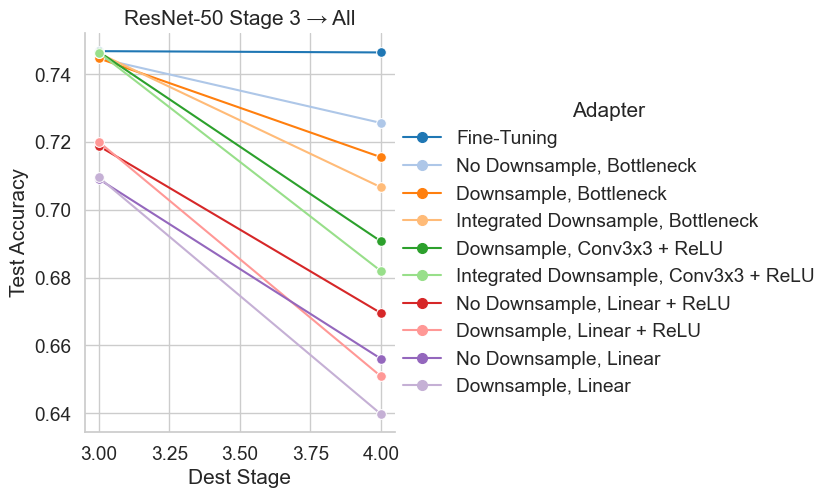

In [348]:
_ = plot_accuracy_vs_depth(best_of_lrs, src_stage=current_src_stage, arch_choice="ResNet-50")

Saving plot: ../experiments/across-scales/figures/resnet-50-stage-3-to-all-acc-vs-size.(pdf/png)


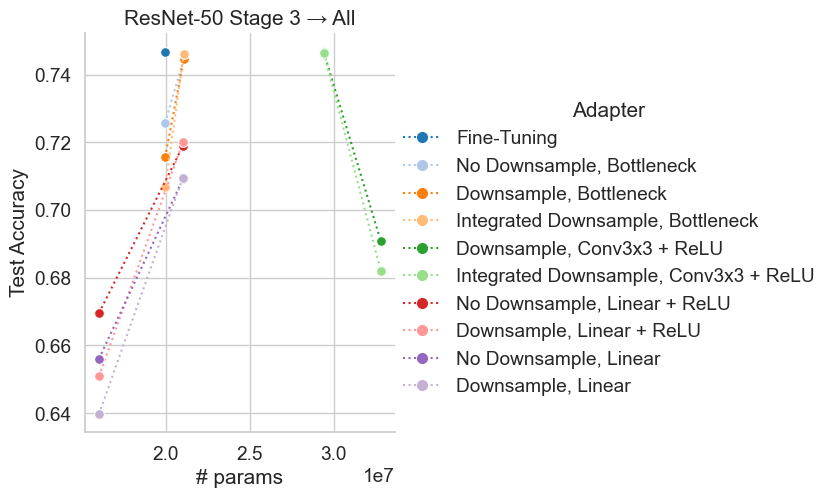

In [349]:
_ = plot_accuracy_vs_size(best_of_lrs, src_stage=current_src_stage, arch_choice="ResNet-50")

Saving plot: ../experiments/across-scales/figures/resnet-50-stage-3-to-all-acc-vs-flops.(pdf/png)


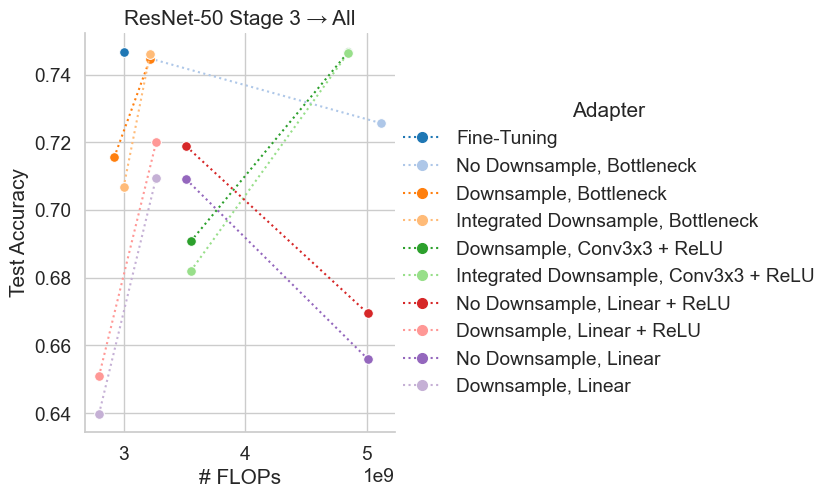

In [350]:
_ = plot_accuracy_vs_flops(best_of_lrs, src_stage=current_src_stage, arch_choice="ResNet-50", kind="line")

Saving plot: ../experiments/across-scales/figures/swin-t-stage-3-to-all-acc-vs-depth.(pdf/png)


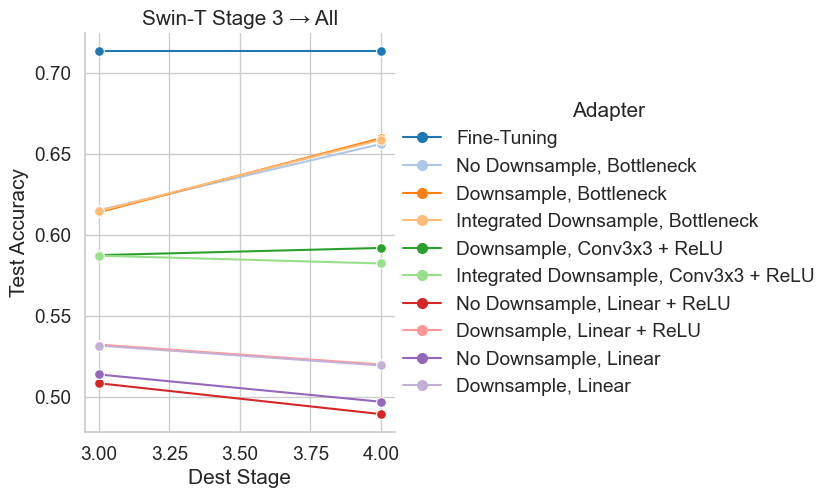

In [351]:
_ = plot_accuracy_vs_depth(best_of_lrs, src_stage=current_src_stage, arch_choice="Swin-T")

Saving plot: ../experiments/across-scales/figures/swin-t-stage-3-to-all-acc-vs-size.(pdf/png)


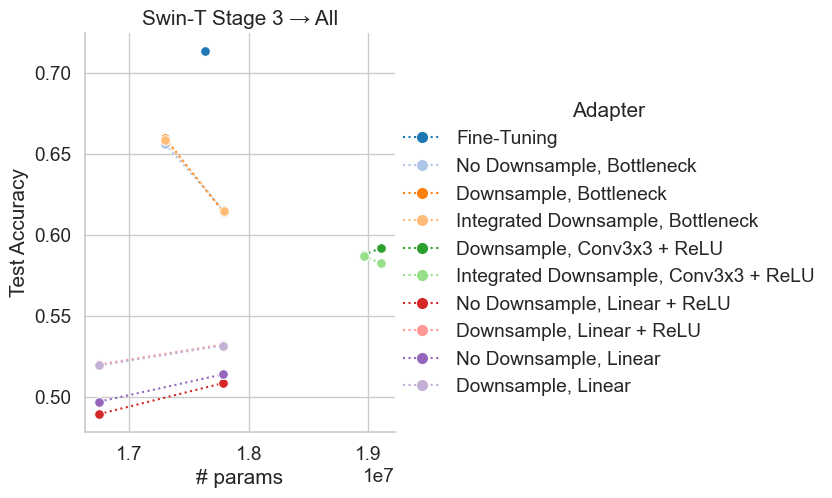

In [352]:
_ = plot_accuracy_vs_size(best_of_lrs, src_stage=current_src_stage, arch_choice="Swin-T")

Saving plot: ../experiments/across-scales/figures/swin-t-stage-3-to-all-acc-vs-flops.(pdf/png)


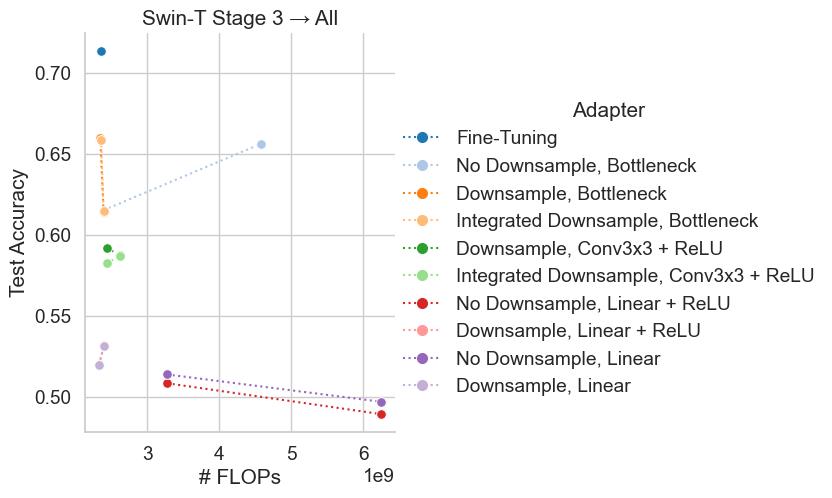

In [353]:
_ = plot_accuracy_vs_flops(best_of_lrs, src_stage=current_src_stage, arch_choice="Swin-T")

Saving plot: ../experiments/across-scales/figures/mobilenetv3-stage-3-to-all-acc-vs-depth.(pdf/png)


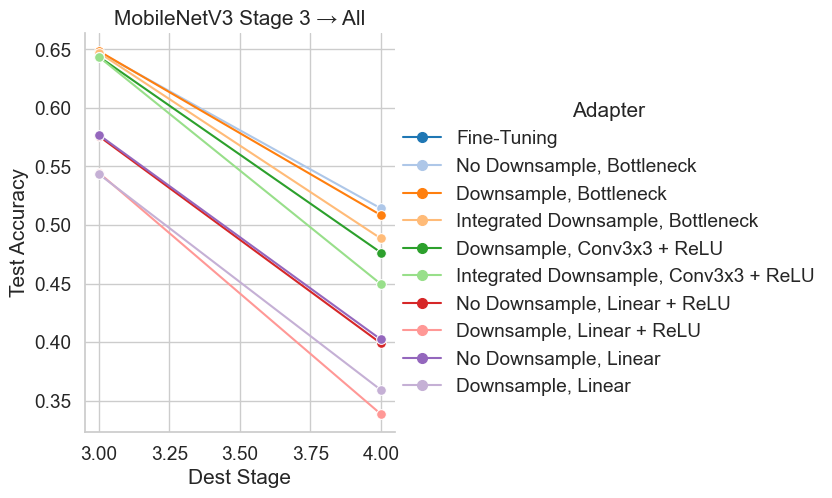

In [354]:
_ = plot_accuracy_vs_depth(best_of_lrs, src_stage=current_src_stage, arch_choice="MobileNetV3")

Saving plot: ../experiments/across-scales/figures/mobilenetv3-stage-3-to-all-acc-vs-size.(pdf/png)


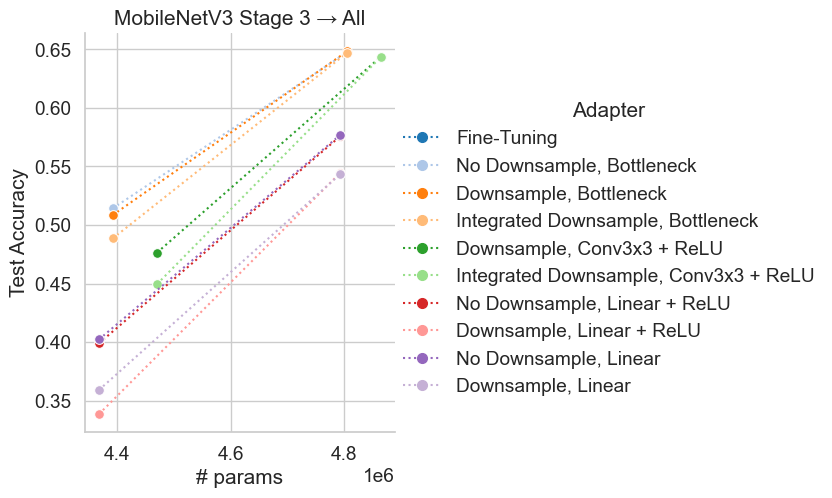

In [355]:
_ = plot_accuracy_vs_size(best_of_lrs, src_stage=current_src_stage, arch_choice="MobileNetV3")

Saving plot: ../experiments/across-scales/figures/mobilenetv3-stage-3-to-all-acc-vs-flops.(pdf/png)


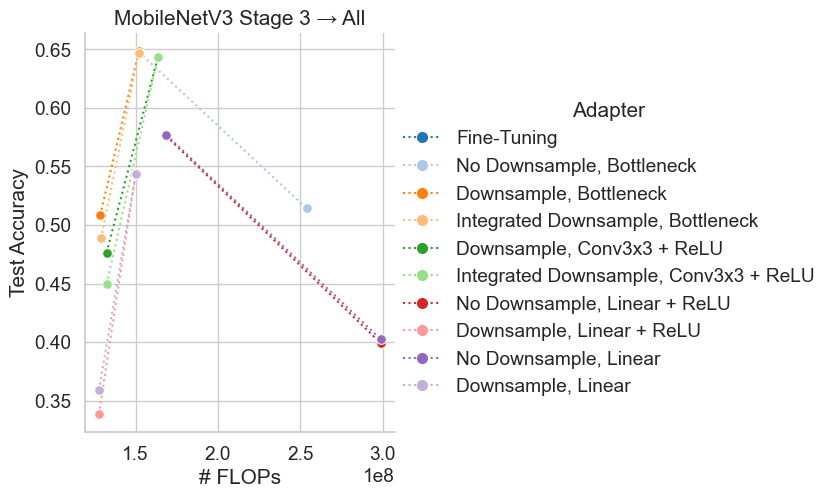

In [356]:
_ = plot_accuracy_vs_flops(best_of_lrs, src_stage=current_src_stage, arch_choice="MobileNetV3")

Saving plot: ../experiments/across-scales/figures/resnet-50-swin-t-stage-3-to-all-acc-vs-depth.(pdf/png)


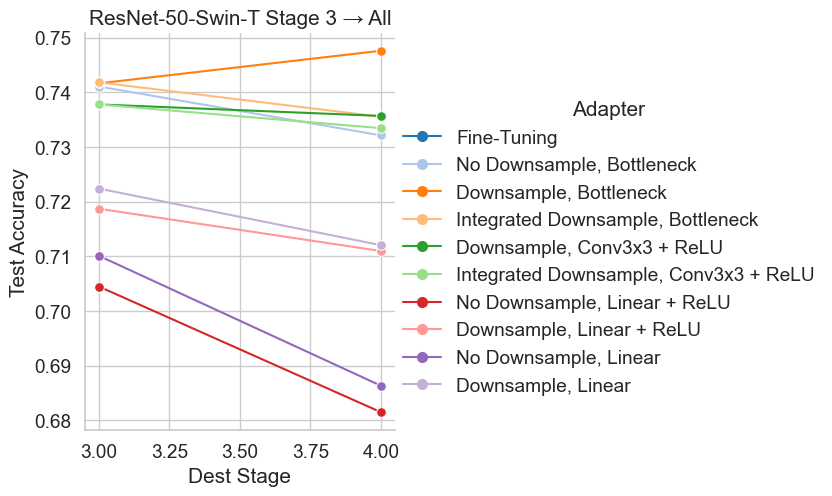

In [357]:
_ = plot_accuracy_vs_depth(best_of_lrs, src_stage=current_src_stage, arch_choice="ResNet-50-Swin-T")

Saving plot: ../experiments/across-scales/figures/resnet-50-swin-t-stage-3-to-all-acc-vs-size.(pdf/png)


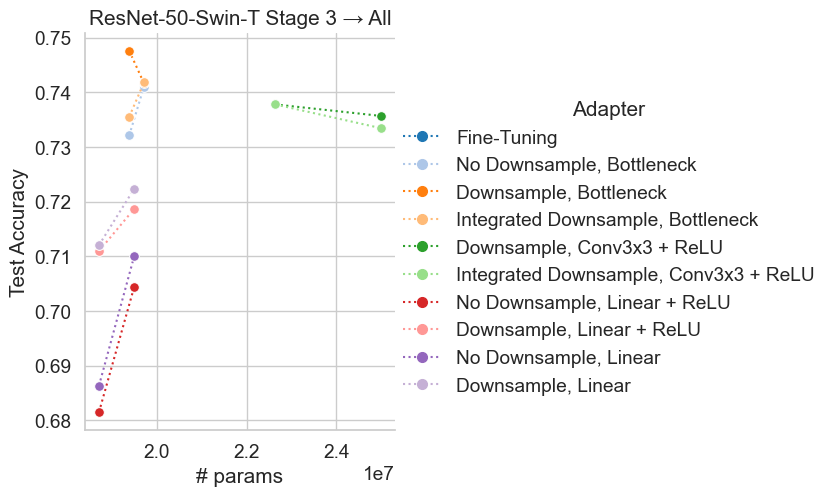

In [358]:
_ = plot_accuracy_vs_size(best_of_lrs, src_stage=current_src_stage, arch_choice="ResNet-50-Swin-T")

Saving plot: ../experiments/across-scales/figures/resnet-50-swin-t-stage-3-to-all-acc-vs-flops.(pdf/png)


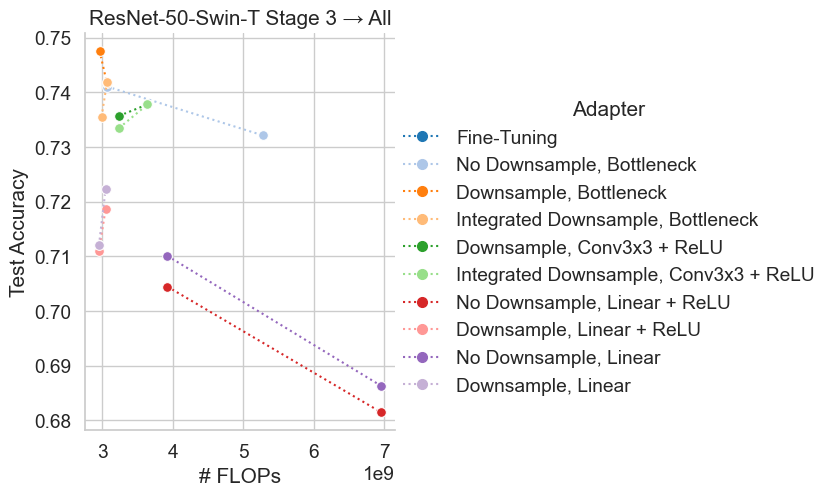

In [359]:
_ = plot_accuracy_vs_flops(best_of_lrs, src_stage=current_src_stage, arch_choice="ResNet-50-Swin-T")

# Learning Rate Ablations

In [376]:
archname = "Swin-T"
lr_archs = [
    f"{archname}-lr-1.0e-2",
    f"{archname}",
    f"{archname}-lr-2.0e-4",
    # f"{archname}-lr-2.0e-4-wd-0.01",
]
wd_archs = [
    f"{archname}-wd-0.01",
    f"{archname}",
    f"{archname}-wd-0.3",
]
LR_ADAPTERS = [
    "Fine-Tuning",
    "Downsample, Bottleneck",
    "Downsample, Conv3x3 + ReLU",
    "Downsample, Linear",
]

Saving plot: ../experiments/across-scales/figures/swin-t-lr-1.0e-2-stage-3-to-all-acc-vs-depth.(pdf/png)
Saving plot: ../experiments/across-scales/figures/swin-t-stage-3-to-all-acc-vs-depth.(pdf/png)
Saving plot: ../experiments/across-scales/figures/swin-t-lr-2.0e-4-stage-3-to-all-acc-vs-depth.(pdf/png)


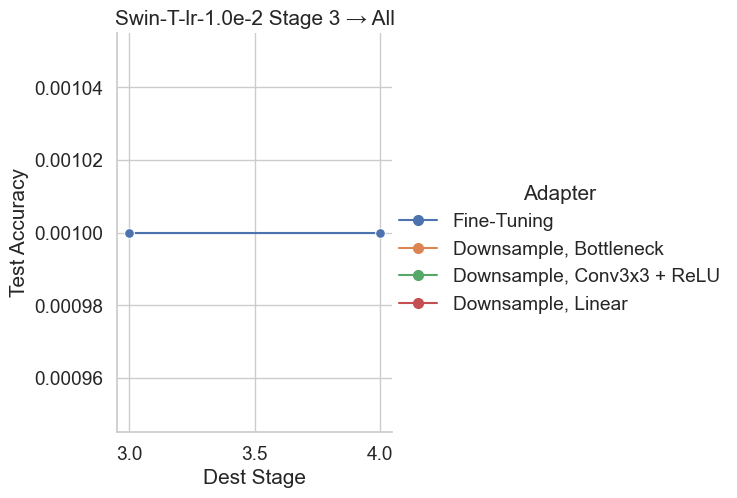

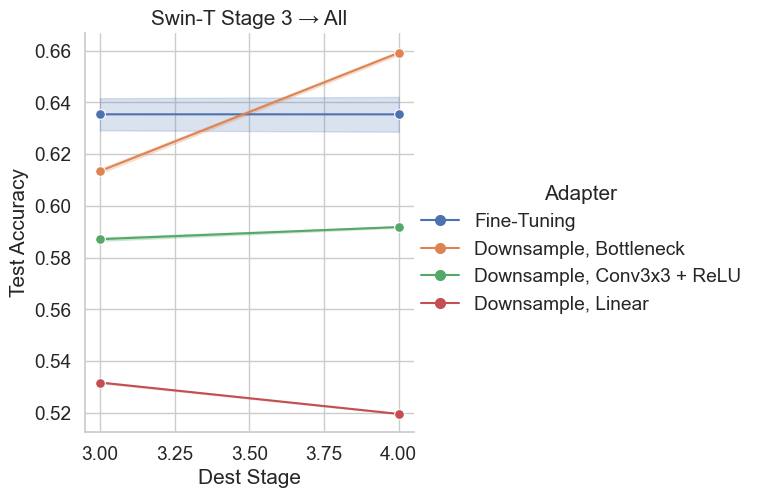

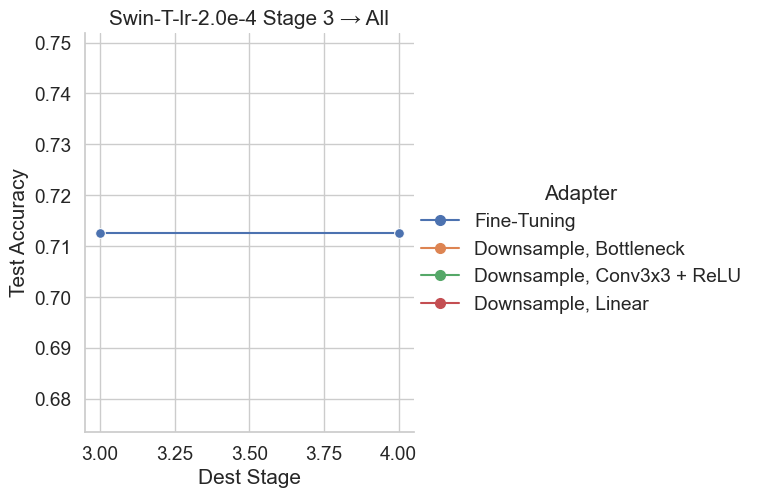

In [377]:
for arch in lr_archs:
    _ = plot_accuracy_vs_depth(final_df, src_stage=current_src_stage, arch_choice=arch, adapter_choice=LR_ADAPTERS)

In [378]:
lr_rows = final_df.index.get_level_values("Architecture").str.fullmatch(f"{archname}(-lr.*)?")
selected_lr_archs = final_df.loc[lr_rows]
group_cols = list(set(selected_lr_archs.index.names) - {"Seed", "Step", "Architecture"})
best_learning_rate = selected_lr_archs.groupby(group_cols).max()
best_learning_rate = best_learning_rate.sort_values(["Adapter", "first_deleted_block", "last_deleted_block"])

Saving plot: ../experiments/across-scales/figures/best-of-all-lrs---swin-t-stage-3-to-all-acc-vs-depth.(pdf/png)


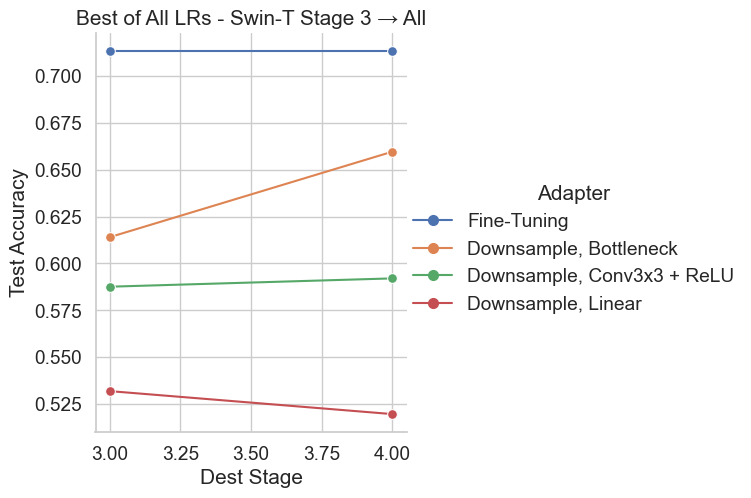

In [379]:
_ = plot_accuracy_vs_depth(best_learning_rate, src_stage=current_src_stage, adapter_choice=LR_ADAPTERS,
                           name=f"Best of All LRs - {archname}")

Saving plot: ../experiments/across-scales/figures/different-lrs---swin-t-stage-3-to-all---fine-tuning-acc-vs-depth.(pdf/png)


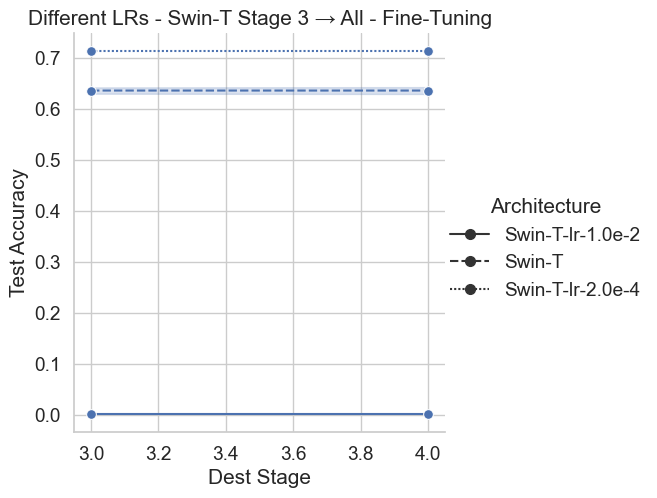

In [380]:
_ = plot_accuracy_vs_depth(final_df, src_stage=current_src_stage, arch_choice=lr_archs, adapter_choice="Fine-Tuning",
                           name=f"Different LRs - {archname}")

Saving plot: ../experiments/across-scales/figures/different-lrs---swin-t-stage-3-to-all---downsample,-bottleneck-acc-vs-depth.(pdf/png)


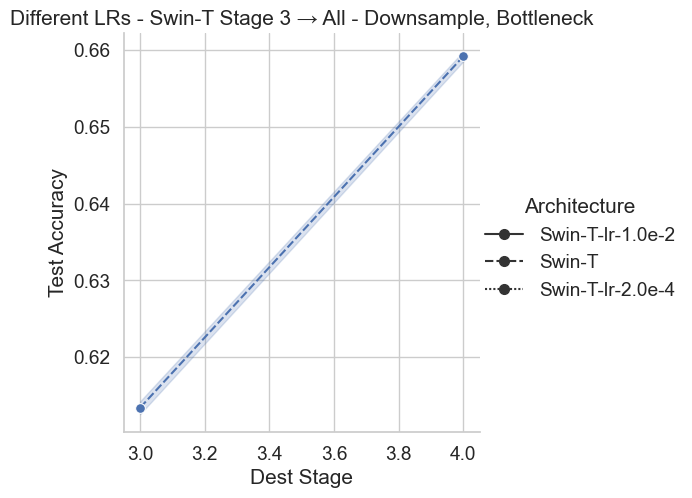

In [381]:
_ = plot_accuracy_vs_depth(final_df, src_stage=current_src_stage, arch_choice=lr_archs,
                           adapter_choice="Downsample, Bottleneck", name=f"Different LRs - {archname}")

Saving plot: ../experiments/across-scales/figures/different-lrs---swin-t-stage-3-to-all---integrated-downsample,-bottleneck-acc-vs-depth.(pdf/png)


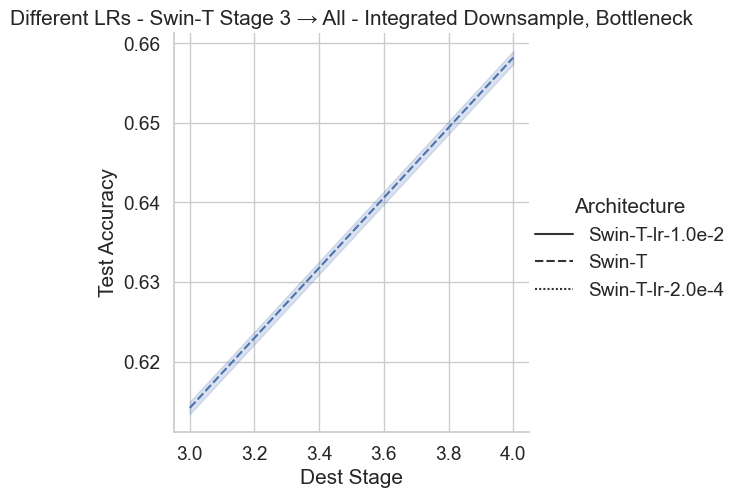

In [382]:
_ = plot_accuracy_vs_depth(final_df, src_stage=current_src_stage, arch_choice=lr_archs,
                           adapter_choice="Integrated Downsample, Bottleneck", name=f"Different LRs - {archname}",
                           marker=None)

In [383]:
wd_rows = final_df.index.get_level_values("Architecture").str.fullmatch(f"{archname}(-wd.*)?")
selected_wd_archs = final_df.loc[wd_rows]
group_cols = list(set(selected_wd_archs.index.names) - {"Seed", "Step", "Architecture"})
best_weight_decay = selected_wd_archs.groupby(group_cols).max()
best_weight_decay = best_weight_decay.sort_values(["Adapter", "first_deleted_block", "last_deleted_block"])

Saving plot: ../experiments/across-scales/figures/best-of-all-wds---resnet-50-stage-3-to-all-acc-vs-depth.(pdf/png)


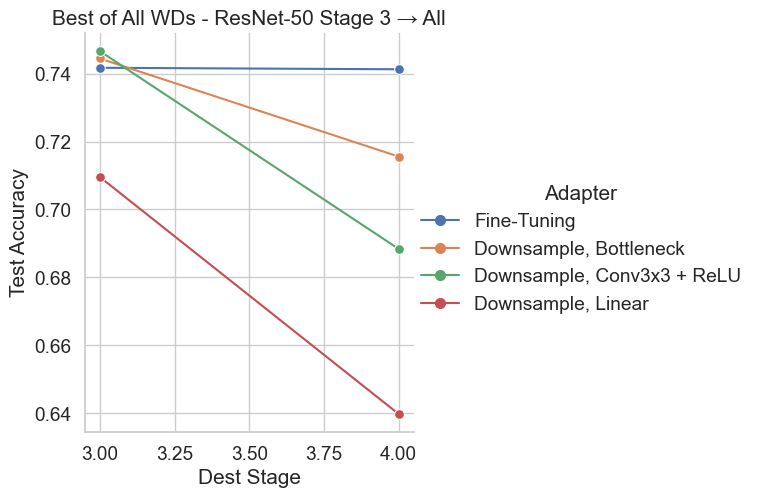

In [373]:
_ = plot_accuracy_vs_depth(best_weight_decay, src_stage=current_src_stage, adapter_choice=LR_ADAPTERS,
                           name=f"Best of All WDs - {archname}")

Saving plot: ../experiments/across-scales/figures/different-wds---resnet-50-stage-3-to-all---fine-tuning-acc-vs-depth.(pdf/png)


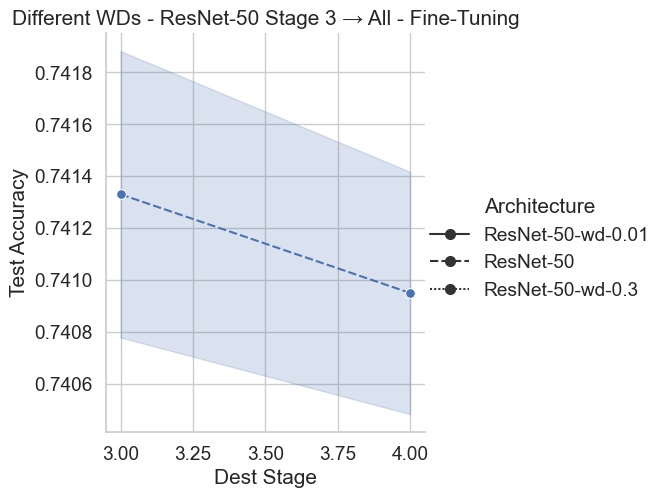

In [374]:
_ = plot_accuracy_vs_depth(final_df, src_stage=current_src_stage, arch_choice=wd_archs, adapter_choice="Fine-Tuning",
                           name=f"Different WDs - {archname}")

Saving plot: ../experiments/across-scales/figures/different-wds---resnet-50-stage-3-to-all---downsample,-linear-acc-vs-depth.(pdf/png)


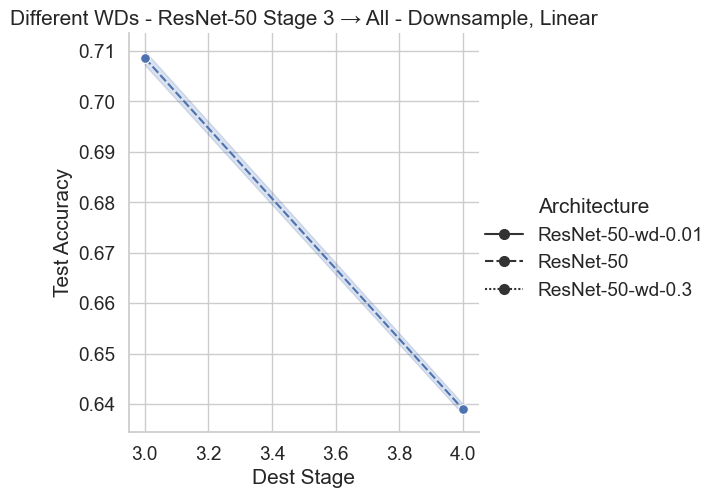

In [375]:
_ = plot_accuracy_vs_depth(final_df, src_stage=current_src_stage, arch_choice=wd_archs,
                           adapter_choice="Downsample, Linear", name=f"Different WDs - {archname}")

# Sandbox

In [183]:
best_of_lrs.loc[
    best_of_lrs.index.get_level_values("Architecture").str.fullmatch(f"ResNet-50") &
    best_of_lrs.index.get_level_values("Adapter").str.fullmatch(f".*bottleneck.*") &
    (best_of_lrs.index.get_level_values("first_deleted_block") == 5)
]

Overall/Test Accuracy
num_flops  num_trainable_params last_deleted_block num_downsamples arch      num_params Epoch first_deleted_block adapter                                          
2920284160 6039552              6                  1               resnet-50 19971112   10    5                   downsample_then_bottleneck                0.71556
2997354496 6039552              6                  1               resnet-50 19971112   10    5                   bottleneck_with_downsample                0.70668
3215720448 1117184              5                  0               resnet-50 21088296   10    5                   bottleneck_no_downsample                  0.74474
                                                                                                                  bottleneck_with_downsample                0.74620
                                                                                                                  downsample_then_bottleneck                0.74470
5116788736 6039552              6                  1               resnet-50 19971112   10    5                   bottleneck_no_downsample                  0.72566

In [118]:
# Find missing results.
for cfgfile in tqdm(list(sorted(proj_dir.rglob("config.yml")))):
    result_files = list(cfgfile.parent.glob("result*.pkl"))
    if not result_files:
        print(f"Missing: {cfgfile.parent}")

100%|██████████| 598/598 [00:00<00:00, 40304.57it/s]

Missing: ../experiments/across-scales/mobilenet-v3/train-mobilenet-v3-gap-1,4-adapter-bottleneck_no_downsample
Missing: ../experiments/across-scales/mobilenet-v3/train-mobilenet-v3-gap-1,4-adapter-linear_no_downsample
Missing: ../experiments/across-scales/mobilenet-v3/train-mobilenet-v3-gap-1,4-adapter-linear_relu_no_downsample
Missing: ../experiments/across-scales/mobilenet-v3/train-mobilenet-v3-gap-1,6-adapter-bottleneck_no_downsample
Missing: ../experiments/across-scales/mobilenet-v3/train-mobilenet-v3-gap-1,6-adapter-finetune
Missing: ../experiments/across-scales/mobilenet-v3/train-mobilenet-v3-gap-1,6-adapter-linear_no_downsample
Missing: ../experiments/across-scales/mobilenet-v3/train-mobilenet-v3-gap-1,6-adapter-linear_relu_no_downsample
Missing: ../experiments/across-scales/mobilenet-v3/train-mobilenet-v3-gap-3,6-adapter-finetune
Missing: ../experiments/across-scales/mobilenet-v3-lr-2.0e-4/train-mobilenet-v3-lr-2.0e-4-gap-1,6-adapter-finetune
Missing: ../experiments/across-scal